In [43]:
import pandas as pd 
import xml.etree.ElementTree as et 

xtree = et.parse("bessbike.tcx")
xroot = xtree.getroot() 

df_cols = ["time","latitude","longitude","distanceinmeters","heartrate"]
rows = []





In [44]:
xroot

<Element '{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}TrainingCenterDatabase' at 0x7fe7980e3810>

In [45]:
xroot[0][0][1].tag

'{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Lap'

Parses through tcx file to find relevant information and creates a pandas data fram

In [46]:
ctr=0
for lap in xroot[0][0].findall("{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Lap"):
    for node in lap[8].findall("{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Trackpoint"):
        if node[1].tag == "{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Position":
            time = node[0].text
            lat = node[1][0].text
            long = node[1][1].text
            dist= node[3].text
            bpm = node[4][0].text

            rows.append({"time": time, "latitude": lat, 
                            "longitude": long, "distanceinmeters": dist,
                            "heartrate":bpm})

    tracking_df = pd.DataFrame(rows, columns = df_cols)

In [47]:
tracking_df

,time,latitude,longitude,distanceinmeters,heartrate
0,2021-05-02T02:18:30.000Z,32.882233802229166,-117.23948881030083,0.550000011920929,98
1,2021-05-02T02:18:31.000Z,32.882233802229166,-117.23948881030083,0.550000011920929,97
2,2021-05-02T02:18:41.000Z,32.882172195240855,-117.239481350407,9.380000114440918,96
3,2021-05-02T02:18:47.000Z,32.88206188939512,-117.23938076756895,24.809999465942383,93
4,2021-05-02T02:18:59.000Z,32.8817330673337,-117.23927197046578,63.349998474121094,90
...,...,...,...,...,...
158,2021-05-02T02:34:16.000Z,32.87783053703606,-117.23759919404984,3257.43994140625,106
159,2021-05-02T02:34:30.000Z,32.878309143707156,-117.23756960593164,3310.429931640625,107
160,2021-05-02T02:34:45.000Z,32.87878188304603,-117.23756273277104,3363.070068359375,105
161,2021-05-02T02:34:54.000Z,32.87902554497123,-117.23754990845919,3390.820068359375,105


In [1]:
##formats the time
def time_splitter (row):
   datetime=row['time'].split("T")
   return datetime[1]
  

In [49]:
tracking_df["HHMMSS"]=tracking_df.apply (lambda row: time_splitter(row), axis=1)

In [50]:
tracking_df

,time,latitude,longitude,distanceinmeters,heartrate,HHMMSS
0,2021-05-02T02:18:30.000Z,32.882233802229166,-117.23948881030083,0.550000011920929,98,02:18:30.000Z
1,2021-05-02T02:18:31.000Z,32.882233802229166,-117.23948881030083,0.550000011920929,97,02:18:31.000Z
2,2021-05-02T02:18:41.000Z,32.882172195240855,-117.239481350407,9.380000114440918,96,02:18:41.000Z
3,2021-05-02T02:18:47.000Z,32.88206188939512,-117.23938076756895,24.809999465942383,93,02:18:47.000Z
4,2021-05-02T02:18:59.000Z,32.8817330673337,-117.23927197046578,63.349998474121094,90,02:18:59.000Z
...,...,...,...,...,...,...
158,2021-05-02T02:34:16.000Z,32.87783053703606,-117.23759919404984,3257.43994140625,106,02:34:16.000Z
159,2021-05-02T02:34:30.000Z,32.878309143707156,-117.23756960593164,3310.429931640625,107,02:34:30.000Z
160,2021-05-02T02:34:45.000Z,32.87878188304603,-117.23756273277104,3363.070068359375,105,02:34:45.000Z
161,2021-05-02T02:34:54.000Z,32.87902554497123,-117.23754990845919,3390.820068359375,105,02:34:54.000Z


In [51]:
tracking_df.distanceinmeters=tracking_df.distanceinmeters.astype(str).astype(float)

In [52]:
##creates a column of the difference of meters between two data points
meterscol=[]
for i,j in enumerate(tracking_df.distanceinmeters):
    meters=0
    if i>0:
        lastmet=tracking_df.distanceinmeters[i-1]
        met =j
        meters=met-lastmet
    meterscol.append(meters)


    

In [53]:
tracking_df["meters"]=meterscol

In [54]:
## creates a column of seconds between data points
secondscol=[]
for i,j in enumerate(tracking_df.HHMMSS):
    seconds=0
    if i>0:
        lastmins=int(tracking_df.HHMMSS[i-1][3:5])
        lastsecs=int(tracking_df.HHMMSS[i-1][6:8])
        mins=int(j[3:5])
        secs=int(j[6:8])
        if lastmins==mins:
            seconds=secs-lastsecs
        else:
            seconds = (60-lastsecs)+secs
    secondscol.append(seconds)


In [55]:
tracking_df["seconds"]=secondscol

In [56]:
## calculates milesperhour using meters and seconds
def calculate_speed(row):
    if (row.seconds>0):
        meterspersecond=row.meters/row.seconds
        milesperhour=meterspersecond*2.237
        return milesperhour
    else: return 0


In [57]:
tracking_df["mph"]=tracking_df.apply (lambda row: calculate_speed(row), axis=1)

In [59]:
## removes outliers, they are probably errors
tracking_df = tracking_df[tracking_df.mph < 85]

In [60]:
tracking_df

,time,latitude,longitude,distanceinmeters,heartrate,HHMMSS,meters,seconds,mph
0,2021-05-02T02:18:30.000Z,32.882233802229166,-117.23948881030083,0.550000,98,02:18:30.000Z,0.000000,0,0.000000
1,2021-05-02T02:18:31.000Z,32.882233802229166,-117.23948881030083,0.550000,97,02:18:31.000Z,0.000000,1,0.000000
2,2021-05-02T02:18:41.000Z,32.882172195240855,-117.239481350407,9.380000,96,02:18:41.000Z,8.830000,10,1.975271
3,2021-05-02T02:18:47.000Z,32.88206188939512,-117.23938076756895,24.809999,93,02:18:47.000Z,15.429999,6,5.752818
4,2021-05-02T02:18:59.000Z,32.8817330673337,-117.23927197046578,63.349998,90,02:18:59.000Z,38.539999,12,7.184498
...,...,...,...,...,...,...,...,...,...
158,2021-05-02T02:34:16.000Z,32.87783053703606,-117.23759919404984,3257.439941,106,02:34:16.000Z,52.409912,14,8.374355
159,2021-05-02T02:34:30.000Z,32.878309143707156,-117.23756960593164,3310.429932,107,02:34:30.000Z,52.989990,14,8.467043
160,2021-05-02T02:34:45.000Z,32.87878188304603,-117.23756273277104,3363.070068,105,02:34:45.000Z,52.640137,15,7.850399
161,2021-05-02T02:34:54.000Z,32.87902554497123,-117.23754990845919,3390.820068,105,02:34:54.000Z,27.750000,9,6.897417


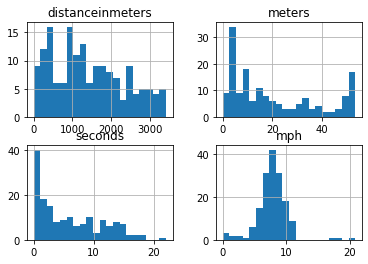

In [61]:
hist = tracking_df.hist(bins=20)

In [62]:
## creates csv out of finalized data frame
tracking_df.to_csv(r'training csv/bessbike.csv', index = False)